## Modelling Drug Protein Interactions with Isothermal-Titration Calorimetry (ITC)
In an ITC experiment, aliquots of a ligand (drug) in a syringe is periodically injected into a reaction cell containing a macromolecule (protein). The reaction is essentially a complexation reaction where the ligand is injected until the macromolecule reaches saturation. The saturation of the macromolecule indicates the end of the titration.  Titration of Calcium chloride (CaCl2) into EDTA is a well known and characterized experiment used as a standard for ITC experiments. 

First, we generated a model from scratch using the principles of energy and mass conservation by writing energy and mass balance equations for our system. Then we tested our model with Ca-EDTA experimental data to validate the model and compared it with an elaborate theoritical model developed by (Dumas, 2019), here in referred to as the Dumas model. Fitting of our model to experimental data showed a step change between the saturated (lower section) and unsaturated region(upper section) of the binding isotherm. The fit returned a negative R squared value. This could be due to over approximation in our model. The Dumas Model yielded a better fit and an R squared value of 0.94. 
We employed this model model to fit out Drug-Protein reaction. 


## Section 1   : Validating our model with Ca-EDTA experimental data



In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from numpy import sqrt 
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score 
x = pd.read_excel(r'/Users/mac/Downloads/modelling meeting/Ca-EDTA Data only.xlsx')
x.head()

,Region,Q (µJ),Corrected Q (µJ),inj volume (µL),moles titrant (moles),moles titrate (moles),moles titrant / moles titrate,total volume (µL),inj interval (s),i
0,1,-26.366210,-13.104910,9.975,9.975000e-09,1.200000e-07,0.083125,809.975,300,1
1,2,-185.315424,-172.054124,9.975,1.995000e-08,1.200000e-07,0.166250,819.950,300,2
2,3,-179.939055,-166.677755,9.975,2.992500e-08,1.200000e-07,0.249375,829.925,300,3
3,4,-183.457728,-170.196428,9.975,3.990000e-08,1.200000e-07,0.332500,839.900,300,4
4,5,-191.176430,-177.915130,9.975,4.987500e-08,1.200000e-07,0.415625,849.875,300,5


In [3]:
#Experiment parameters

Vo=800 #Initial volume of EDTA in the cell, uL
v= 9.975 #Volume of CaCl2 per injection, uL
Lo= 1 # Concentration of CaCl2 in the syringe, mM
Mo=0.150 #Concentration of EDTA in the cell , mM

#Parameters to calculate
#Mt,#Lt, #ML,#ML[i-1] = ML2,#Lt[i-1]=L2t,#Mt[i-1]=M2t,#n

In [4]:
#MLi vector and list generation for i,Mt and Lt 
Region = np.array(list(range(0,25)))  
Mt = []
Lt = []
Mt_below = []
Lt_below = []
for idx, i in enumerate(Region):
    try: 
        Mt_= Mo*(1-v/Vo)**(i)
        Lt_= Lo*(1-(1-v/Vo)**((i)))
        Mt.append(Mt_)
        Lt.append(Lt_)

        Mt_below_= Mo*(1-v/Vo)**(Region[idx+1])
        Lt_below_= Lo*(1-(1-v/Vo)**(Region[idx+1]))
        Mt_below.append(Mt_below_)
        Lt_below.append(Lt_below_)
    except: 
        pass

Mt_below.append(0)
Lt_below.append(0)



In [5]:
#Making Lt and Mt arrays
Mt = np.array(Mt)
Lt = np.array(Lt)
Mt_below = np.array(Mt_below)
Lt_below = np.array(Lt_below)
N = np.array(Lt/Mt)

matrix = np.row_stack((Region, Mt, Lt, Mt_below, Lt_below))

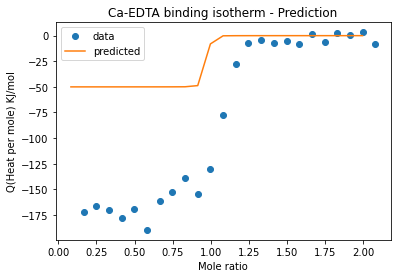

In [6]:

#### Qpi predicts heat values according to our model. 
def Qpi(matrix,H,Ka,N):
    '''
    Function that returns predicted heat value. 
    '''
    i,Mt, Lt, Mt_below, Lt_below = matrix 
    A= 1+Ka*(Mt+Lt)
    A_below = 1+Ka*(Mt_below+Lt_below)
    B= sqrt((A**2)-(4*Ka**2*Mt*Lt))
    B_below = sqrt((A_below**2)-(4*Ka**2*Mt_below*Lt_below))
    ML=((A-B)/(2*Ka))
    ML_below = ((A_below-B_below)/(2*Ka))
    Qpi=((Vo*10*H)/(v*Lo))*(ML_below-ML*(1-v/Vo))*N


    return Qpi
                                                  
                                      
H, Ka,N = [-10, 170000,0.5]        #guess parameters                             
results = Qpi(matrix,H,Ka,N)

results
plt.plot(x['moles titrant / moles titrate'].values[1:],x['Corrected Q (µJ)'][1:], 'o', label="data")
plt.plot(x['moles titrant / moles titrate'].values[:-1],results[:-1],label="predicted")
plt.xlabel('Mole ratio')
plt.ylabel('Q(Heat per mole) KJ/mol')
plt.title('Ca-EDTA binding isotherm - Prediction')
plt.legend(loc="best")
plt.savefig('Ca-EDTA binding isotherm - Prediction.png',dpi=300)

In [7]:
#Fitting experimental data to the model equation with scipy.curve_fit 




optimal_parameters,covariance = curve_fit(Qpi,matrix,x['Corrected Q (µJ)'].values,bounds=[[-20,250000,1.0],[-17,300000,1.2]])
parameter_errors = np.sqrt(np.diag(covariance))
print(optimal_parameters,parameter_errors)

[-1.7e+01  2.5e+05  1.0e+00] [1.69369892e+09 2.24336852e+07 9.96293482e+07]


In [8]:
from sklearn.metrics import r2_score 

In [9]:
R_square = r2_score(x['Corrected Q (µJ)'].values,Qpi(matrix,*optimal_parameters))
print(R_square)

-14.445596594460694


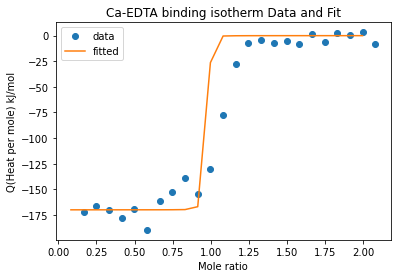

In [10]:
plt.plot(x['moles titrant / moles titrate'].values[1:],x['Corrected Q (µJ)'][1:], 'o', label="data")
plt.plot(x['moles titrant / moles titrate'].values[:-1],Qpi(matrix,*optimal_parameters)[:-1],label="fitted")
plt.xlabel('Mole ratio')
plt.ylabel('Q(Heat per mole) kJ/mol')
plt.title('Ca-EDTA binding isotherm Data and Fit')
plt.legend(loc="best")
plt.savefig('Ca-EDTA binding isotherm - Data and Fit.png',dpi=300)

## Section 2 :  Drug - Protein Data Analysis with our generated model. The drug is Carvedilol and the protein is Mucin. 



In [11]:
y = pd.read_excel(r'/Users/mac/Downloads/modelling meeting/Mucin Carvedilol Data (1) (1).xlsx')
y.head()

,Region,Q (µJ),Corrected Q (µJ),inj volume (µL),moles titrant (moles),moles titrate (moles),moles titrant / moles titrate,total volume (µL),inj interval (s)
0,1,-12.623274,-18.730724,9.975,1.915200e-09,6.184000e-09,0.309702,809.975,300
1,2,-50.921046,-57.028496,9.975,3.830400e-09,6.184000e-09,0.619405,819.950,300
2,3,-39.431629,-45.539079,9.975,5.745600e-09,6.184000e-09,0.929107,829.925,300
3,4,-21.759127,-27.866577,9.975,7.660800e-09,6.184000e-09,1.238810,839.900,300
4,5,-21.499471,-27.606921,9.975,9.576000e-09,6.184000e-09,1.548512,849.875,300


In [12]:
#Experiment parameters

Vo_=800 #Initial volume of EDTA in the cell, uL
v_= 9.975 #Volume of CaCl2 per injection, uL
Lo_= 0.192 # Concentration of CaCl2 in the syringe, mM
Mo_=0.0077 #Concentration of EDTA in the cell , mM

#Parameters to calculate
#Mt,#Lt, #ML,#ML[i-1] = ML2,#Lt[i-1]=L2t,#Mt[i-1]=M2t,#n

In [13]:
#MLi vector and list generation for i,Mt and Lt 
Region_ = np.array(list(range(0,25)))  
Mt_ = []
Lt_ = []
Mt_below_ = []
Lt_below_ = []
for idx, i in enumerate(Region_):
    try: 
        Mt__= Mo_*(1-v_/Vo_)**(i)
        Lt__= Lo_*(1-(1-v_/Vo_)**((i)))
        Mt_.append(Mt__)
        Lt_.append(Lt__)

        Mt_below__= Mo_*(1-v_/Vo_)**(Region_[idx+1])
        Lt_below__= Lo_*(1-(1-v_/Vo_)**(Region_[idx+1]))
        Mt_below_.append(Mt_below__)
        Lt_below_.append(Lt_below__)
    except: 
        pass

Mt_below_.append(0)
Lt_below_.append(0)



In [14]:
#Making Lt and Mt arrays
Mt_ = np.array(Mt_)
Lt_ = np.array(Lt_)
Mt_below_ = np.array(Mt_below_)
Lt_below_ = np.array(Lt_below_)
N_ = np.array(Lt_/Mt_)

matrix_ = np.row_stack((Region_, Mt_, Lt_, Mt_below_, Lt_below_))

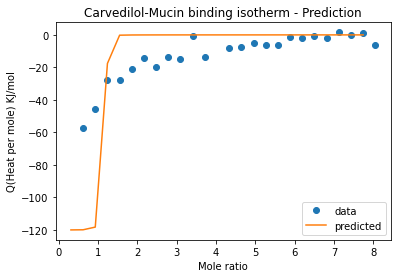

In [15]:

#### Qpi_ predicts heat values according to our model. 
def Qpi_(matrix_,H_,Ka_,N_):
    '''
    Function that returns predicted heat value. 
    '''
    i,Mt_, Lt_, Mt_below_, Lt_below_ = matrix_ 
    A_= 1+Ka_*(Mt_+Lt_)
    A_below_ = 1+Ka_*(Mt_below_+Lt_below_)
    B_= sqrt((A_**2)-(4*Ka_**2*Mt_*Lt_))
    B_below_ = sqrt((A_below_**2)-(4*Ka_**2*Mt_below_*Lt_below_))
    ML_=((A_-B_)/(2*Ka_))
    ML_below_ = ((A_below_-B_below_)/(2*Ka_))
    Qpi_=((Vo_*10*H_)/(v_*Lo_))*(ML_below_-ML_*(1-v_/Vo_))*N_


    return Qpi_
                                                  
                                      
H_, Ka_,N_ = [-120, 500000,0.1]        #guess parameters                             
results_ = Qpi_(matrix_,H_,Ka_,N_)

results_
plt.plot(y['moles titrant / moles titrate'].values[1:],y['Corrected Q (µJ)'][1:], 'o', label="data")
plt.plot(y['moles titrant / moles titrate'].values[:-1],results_[:-1],label="predicted")
plt.xlabel('Mole ratio')
plt.ylabel('Q(Heat per mole) KJ/mol')
plt.title('Carvedilol-Mucin binding isotherm - Prediction')
plt.legend(loc="best")
plt.savefig('Carvedilol-Mucin binding isotherm - Prediction.png',dpi=300)

In [16]:
#Fitting experimental data to the model equation with scipy.curve_fit 




optimal_parameters,covariance = curve_fit(Qpi_,matrix_,y['Corrected Q (µJ)'].values,bounds=[[-30,30000,0.1],[10,60000,0.5]])
parameter_errors = np.sqrt(np.diag(covariance))
print(optimal_parameters,parameter_errors)

[-5.17890225e+00  6.00000000e+04  2.51664711e-01] [2.97935393e+08 1.35922930e+06 1.44779378e+07]


In [17]:
R_square = r2_score(y['Corrected Q (µJ)'].values,Qpi_(matrix_,*optimal_parameters))
print(R_square)

-0.500500143021819


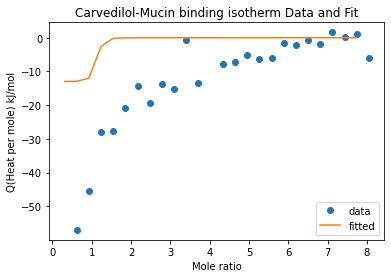

In [18]:
plt.plot(y['moles titrant / moles titrate'].values[1:],y['Corrected Q (µJ)'][1:], 'o', label="data")
plt.plot(y['moles titrant / moles titrate'].values[:-1],Qpi_(matrix_,*optimal_parameters)[:-1],label="fitted")
plt.xlabel('Mole ratio')
plt.ylabel('Q(Heat per mole) kJ/mol')
plt.title('Carvedilol-Mucin binding isotherm Data and Fit')
plt.legend(loc="best")
plt.savefig('Carvedilol-Mucin binding isotherm - Data and Fit.png',dpi=300)

## Section 3  : Validation of Dumas Model with Ca-EDTA Experimental Data.

  

In [19]:

z = pd.read_excel(r'/Users/mac/Downloads/modelling meeting/Ca-EDTA Data_ Model_Validation  .xlsx')
z.head(25)

,s(exp),Qexp
0,0.000000,NaN
1,0.166250,-41.121923
2,0.249375,-39.836940
3,0.332500,-40.677923
4,0.415625,-42.522737
5,0.498750,-40.376389
6,0.581875,-45.317552
7,0.665000,-38.654584
8,0.748125,-36.510428
9,0.831250,-33.319762


In [20]:
s1 = np.array([0,
0.1663,
0.2494,
0.3325,
0.4156,
0.4988,
0.5819,
0.6650,
0.7481,
0.8313,
0.9144,
0.9975,
1.0806,
1.1638,
1.2469,
1.3300,
1.4131,
1.4963,
1.5794,
1.6625,
1.7456,
1.8288,
1.9119,
1.9950,
2.0781,
])

In [21]:
Qexp = np.array([-41.1219,
-39.8369,
-40.6779,
-42.5227,
-40.3764,
-45.3176,
-38.6546,
-36.5104,
-33.3198,
-36.8368,
-31.1586,
-18.4592,
-6.6799,
-1.7878,
-0.9812,
-1.6151,
-1.1624,
-1.8495,
0.3534,
-1.4658,
0.7315,
0.1017,
0.7949,
-1.9384
])

In [22]:
#Guess parameters
ActiveFraction =0.8
H = -10 #(kcal/mol)
Kd =0.5 #uM
Shift = 0.275038395603541

In [23]:
A0=150 #in uM - cell concentration
B0= 1000 # in uM - syringe concentration

def Qp(s1,H,ActiveFraction,Kd,Shift):
    s2 = s1/ActiveFraction
    r = B0/(ActiveFraction*A0) 
    gamma = B0/Kd #gamma = rc
    c = A0/Kd #Wiseman parameter
    
    Z = []
    for i in range(0,len(s1)):
        z = np.sqrt(((r+gamma)**2)+ 2*s2[i]*(r+gamma+(r-gamma)*gamma) + (s2[i]**2)*((1+gamma)**2))
        Z = np.append(Z,z)
    # print(Z)
    
    Q = []
    for i in range(0,len(s1)-1):
        q = Shift+((1+gamma-((Z[i+1]-Z[i])/(s2[i+1]-s2[i])))/(2*gamma))*10*H
        Q = np.append(Q,q)
    
    return Q

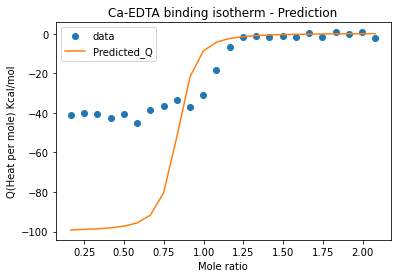

In [24]:
plt.plot(s1[1:],Qexp, 'o',label="data")
plt.plot(s1[1:],Qp(s1,H,ActiveFraction,Kd,Shift),label="Predicted_Q")
plt.xlabel('Mole ratio')
plt.ylabel('Q(Heat per mole) Kcal/mol')
plt.title('Ca-EDTA binding isotherm - Prediction')
plt.legend(loc="best")
    

In [25]:
optimal_parameters,covariance = curve_fit(Qp,s1,Qexp,bounds=[[-50,0.5,0.5,0.275],[50,1.1,1.2,0.6]])
parameter_errors = np.sqrt(np.diag(covariance))
print(optimal_parameters,parameter_errors)



[-4.10817503  1.02914844  0.5         0.275     ] [0.11598672 0.0109113  0.16709777 0.72195791]


In [26]:
R_square = r2_score(Qexp,Qp(s1,*optimal_parameters))
print(R_square)

0.9897054489317347


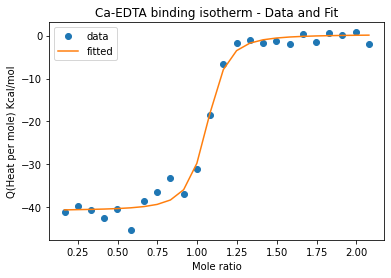

In [27]:
plt.plot(s1[1:],Qexp, 'o',label="data")
plt.plot(s1[1:],Qp(s1,*optimal_parameters),label="fitted")
plt.xlabel('Mole ratio')
plt.ylabel('Q(Heat per mole) Kcal/mol')
plt.title('Ca-EDTA binding isotherm - Data and Fit')
plt.legend(loc="best")

## Section 4 :Data Analysis of Carvedilol-Mucin Experiment with Dumas Model.  



In [32]:
a = pd.read_excel(r'/Users/mac/Downloads/modelling meeting/Mucin Carvedilol Data xlsx.xlsx')
a.head(25)

,Region,s(exp),Q(exp) uJ,Q(exp) ucal
0,1,0.000000,0.000000,0.000000
1,2,0.619405,-57.028496,-13.630138
2,3,0.929107,-45.539079,-10.884101
3,4,1.238810,-27.866577,-6.660272
4,5,1.548512,-27.606921,-6.598212
5,6,1.858215,-20.835550,-4.979816
6,7,2.167917,-14.283615,-3.413866
7,8,2.477620,-19.454248,-4.649677
8,9,2.787322,-13.662097,-3.265320
9,10,3.097025,-15.089138,-3.606390


In [33]:
s1_ = np.array([0,
0.619404916,
0.929107374,
1.238809832,
1.54851229,
1.858214748,
2.167917206,
2.477619664,
2.787322122,
3.09702458,
3.406727038,
3.716429495,
4.335834411,
4.645536869,
4.955239327,
5.264941785,
5.574644243,
5.884346701,
6.194049159,
6.503751617,
6.813454075,
7.123156533,
7.432858991,
7.742561449,
8.052263907
])

In [34]:
Qexp_ = np.array([-13.63013762,
-10.88410121,
-6.66027175,
-6.598212448,
-4.979815979,
-3.413866032,
-4.649676897,
-3.265319529,
-3.6063905,
-0.15945191,
-3.203726338,
-1.882923062,
-1.711174233,
-1.212425424,
-1.482171953,
-1.443574799,
-0.369692559,
-0.483804904,
-0.185388512,
-0.420449152,
0.389597806,
0.039855827,
0.298648043,
-1.413841831
])

In [35]:
#Guess parameters
ActiveFraction_ =0.15
H_ = -18 #(kcal/mol)
Kd_ =15 #uM
Shift_ = 0.6

In [36]:
#Lets make the parameters arrays
#s1_corrected = s1/ActiveFraction
#s2 = s1_corrected
#print(s1_corrected)

In [37]:
A0_=7.73 #in uM - cell concentration
B0_= 192 # in uM - syringe concentration

def Qp_(s1_,H_,ActiveFraction_,Kd_,Shift_):
    s2_ = s1_/ActiveFraction_
    r_ = B0_/(ActiveFraction_*A0_) 
    gamma_ = B0_/Kd_ #gamma = rc
    c_ = A0_/Kd_ #Wiseman parameter
    
    Z_ = []
    for i in range(0,len(s1)):
        z_ = np.sqrt(((r_+gamma_)**2)+ 2*s2_[i]*(r_+gamma_+(r_-gamma_)*gamma_) + (s2_[i]**2)*((1+gamma_)**2))
        Z_ = np.append(Z_,z_)
    # print(Z)
    
    Q_ = []
    for i in range(0,len(s1_)-1):
        q_ = Shift_+((1+gamma_-((Z_[i+1]-Z_[i])/(s2_[i+1]-s2_[i])))/(2*gamma_))*10*H_
        Q_ = np.append(Q_,q_)
    
    return Q_

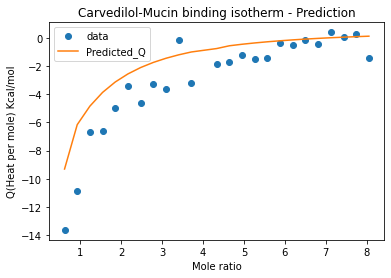

In [38]:
plt.plot(s1_[1:],Qexp_, 'o',label="data")
plt.plot(s1_[1:],Qp_(s1_,H_,ActiveFraction_,Kd_,Shift_),label="Predicted_Q")
plt.xlabel('Mole ratio')
plt.ylabel('Q(Heat per mole) Kcal/mol')
plt.title('Carvedilol-Mucin binding isotherm - Prediction')
plt.legend(loc="best")
    

In [39]:
optimal_parameters,covariance = curve_fit(Qp_,s1_,Qexp_,bounds=[[-50,0.2,10,1],[50,0.5,20,3]])
parameter_errors = np.sqrt(np.diag(covariance))
print(optimal_parameters,parameter_errors)


[-24.31523774   0.2         19.17231764   1.        ] [253.37616928   1.97806685  23.39956765   1.09053767]


In [40]:
R_square = r2_score(Qexp_,Qp_(s1_,*optimal_parameters))
print(R_square)

0.9450819595624241


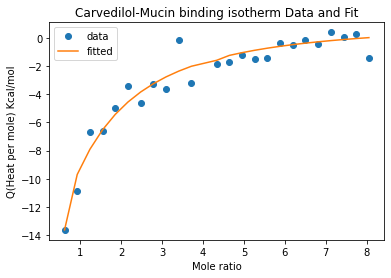

In [41]:
plt.plot(s1_[1:],Qexp_, 'o',label="data")
plt.plot(s1_[1:],Qp_(s1_,*optimal_parameters),label="fitted")
plt.xlabel('Mole ratio')
plt.ylabel('Q(Heat per mole) Kcal/mol')
plt.title('Carvedilol-Mucin binding isotherm Data and Fit')
plt.legend(loc="best")

In [42]:
# sensitivity 

from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp 

In [43]:
morris_problem = {
    'num_vars' : 4, 
    'names' : ['H_','ActiveFraction_','Kd_','Shift_'], 
    'bounds' : [[-50, 50], 
                [0.5, 1.1], 
                [0.5, 1.2], 
                [0.275038395603541,0.6]
               ],
    'groups' : None
    }
       

In [44]:
number_of_trajectories = int(1e1)
sample = ms.sample(morris_problem, number_of_trajectories, num_levels=4)
print(sample.shape)

(50, 4)


In [45]:
output= []
for i in sample: 
    H,Active_fraction,Kd,Shift = i 
    Qp_ = Qp(s1,H,ActiveFraction,Kd,Shift)
    print(Qp_[0])
    output.append(Qp_[15])
    
output_ = np.array(output)

-164.97842711141828
-164.76178604182064
496.685358125462
496.685358125462
494.2340488008919
497.8142141013291
497.8142141013291
495.34757109590237
-164.4602844116992
-164.67692548129685
-494.58085323509766
165.22700227250382
165.22700227250382
165.44364334210147
166.26585767724373
-164.16132400322826
494.01740773129427
494.2340488008919
496.685358125462
496.685358125462
165.14468293363055
165.96178604182055
165.7451449722229
165.7451449722229
-495.7019991950596
165.63682443742408
165.85346550702172
165.03636239883173
165.03636239883173
-493.1423693356907
-164.26964453802708
-164.05300346842944
494.12572826609306
496.57703759066317
496.57703759066317
495.2392505611036
495.2392505611036
497.70589356653034
-165.39081928164026
-165.17417821204262
494.01740773129427
496.4687170558644
-164.97842711141828
-164.76178604182064
-164.76178604182064
-495.81031972985846
-493.35901040528836
164.81972132923408
165.03636239883173
165.03636239883173


In [46]:
sample.shape

(50, 4)

In [47]:
output_.shape

(50,)

In [48]:
# Store the results for plotting of the analysis
Si = ma.analyze(morris_problem, 
                sample, 
                output_, 
                print_to_console=False, 
                num_levels=4)

Name                      mu mu_star   sigma
H_                     15.92   15.92    4.04
ActiveFraction_         0.00    0.00    0.00
Kd_                     3.32    4.41    3.54
Shift_                  0.32    0.32    0.00


Text(0.5, 1.0, 'Sensitivity_Analysis')

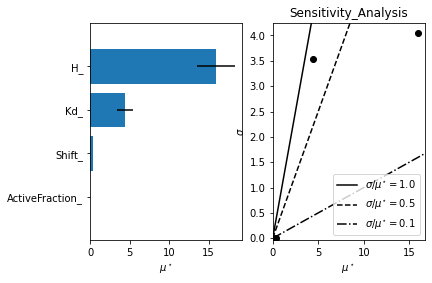

In [49]:
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], Si['mu'], Si['mu_star'], Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))
    
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si) #  param_dict={}
mp.covariance_plot(ax2, Si, {})
plt.title('Sensitivity_Analysis')

In [50]:
fig.savefig('Sensitivity_Analysis.png',dpi=300)